In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
from torchvision import transforms
drive.mount(('/content/drive/'))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import torch
import numpy as np
import torchvision
import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm, metrics

In [3]:
from glob import glob
import pandas

In [4]:
device = 'cuda:0'
num_joints = 21

In [5]:
import torch.nn as nn
import torch
import torch.nn.functional as F

device = 'cuda:0'


# 2d pose estimator - pretrained
class CPM2DPose(nn.Module):
    def __init__(self):
        super(CPM2DPose, self).__init__()
        
        self.scoremap_list = []
        self.layers_per_block = [2, 2, 4, 2]
        self.out_chan_list = [64, 128, 256, 512]
        self.pool_list = [True, True, True, False]

        self.relu = F.leaky_relu
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_1
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv4_7 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=True)  # conv0_2
        self.conv5_1 = nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv5_2 = nn.Conv2d(512, 21, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv6_1 = nn.Conv2d(149, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_2 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_3 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_4 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_5 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv6_6 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv6_7 = nn.Conv2d(128, 21, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv7_1 = nn.Conv2d(149, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_2 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_3 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_4 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_5 = nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, bias=True)  # conv0_2
        self.conv7_6 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.conv7_7 = nn.Conv2d(128, 21, kernel_size=1, stride=1, padding=0, bias=True)  # conv0_2
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc_layer = nn.Sequential( # image -> semantic class로 나오도록
            nn.Linear(21*32*32,256),
            nn.ReLU(),
            nn.Linear(256,3)
        )
        

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        x = self.relu(self.conv3_4(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.relu(self.conv4_4(x))
        x = self.relu(self.conv4_5(x))
        x = self.relu(self.conv4_6(x))
        encoding = self.relu(self.conv4_7(x))
        x = self.relu(self.conv5_1(encoding))
        scoremap = self.conv5_2(x)

        x = torch.cat([scoremap, encoding], 1)
        x = self.relu(self.conv6_1(x))
        x = self.relu(self.conv6_2(x))
        x = self.relu(self.conv6_3(x))
        x = self.relu(self.conv6_4(x))
        x = self.relu(self.conv6_5(x))
        x = self.relu(self.conv6_6(x))
        scoremap = self.conv6_7(x)
        x = torch.cat([scoremap, encoding], 1)
        x = self.relu(self.conv7_1(x))
        x = self.relu(self.conv7_2(x))
        x = self.relu(self.conv7_3(x))
        x = self.relu(self.conv7_4(x))
        x = self.relu(self.conv7_5(x))
        x = self.relu(self.conv7_6(x))
        x = self.conv7_7(x)
        x = torch.flatten(x,1)
        x = self.fc_layer(x)
        return x


In [6]:
'''
class Classifier(nn.Module):
    def __init__(self, batch_size):
        super(Classifier, self).__init__()
        self.batch_size = batch_size

        self.fc_layer = nn.Sequential(
            nn.Linear(21*32*32,256),
            nn.ReLU(),
            nn.Linear(256,3)
        )
      
    def forward(self, x):
        x = x.view(self.batch_size, -1)
        x = self.fc_layer(x)
        return x
'''

'\nclass Classifier(nn.Module):\n    def __init__(self, batch_size):\n        super(Classifier, self).__init__()\n        self.batch_size = batch_size\n\n        self.fc_layer = nn.Sequential(\n            nn.Linear(21*32*32,256),\n            nn.ReLU(),\n            nn.Linear(256,3)\n        )\n      \n    def forward(self, x):\n        x = x.view(self.batch_size, -1)\n        x = self.fc_layer(x)\n        return x\n'

In [7]:
train_img_len = 100
test_img_len = 10

class HandDataset(Dataset):
    def __init__(self, method=None):
        self.x_data = []
        self.y_data = []
        self.z_data = []
        self.root = '/content/drive/My Drive/hand_posture_data'
        self.weight_root = self.root

        if method == 'train':
            self.root = self.root + '/train/' # self.root = drive/My Drive/hand_posture_data/train/
            rock_path = self.root + 'rock/'
            scissors_path = self.root + 'scissors/'
            paper_path = self.root + 'paper/'

            self.rock_img_path = sorted(glob(rock_path + 'rgb/*.jpg'))
            self.scissors_img_path = sorted(glob(scissors_path + 'rgb/*.jpg'))
            self.paper_img_path = sorted(glob(paper_path + 'rgb/*.jpg'))

            self.img_path = self.rock_img_path + self.scissors_img_path + self.paper_img_path

        elif method == 'test':
            self.root = self.root + '/test/' # self.root = drive/My Drive/hand_posture_data/test/
            rock_path = self.root + 'rock/'
            scissors_path = self.root + 'scissors/'
            paper_path = self.root + 'paper/'

            self.rock_img_path = sorted(glob(rock_path + 'rgb/*.jpg'))
            self.scissors_img_path = sorted(glob(scissors_path + 'rgb/*.jpg'))
            self.paper_img_path = sorted(glob(paper_path + 'rgb/*.jpg'))

            self.img_path = self.rock_img_path + self.scissors_img_path + self.paper_img_path

        for i in tqdm.tqdm(range(len(self.img_path))):
            img = cv2.imread(self.img_path[i], cv2.IMREAD_COLOR)
            print(self.img_path[i])  
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            self.x_data.append(img)

            num = self.img_path[i].split('.')[0].split('/')[-1]
            
            if method == 'train':
              if i in range (train_img_len):
                img_pkl = self.root + 'rock/meta/' + str(num) + '.pkl'
              elif i in range (1*train_img_len, 2*train_img_len):
                img_pkl = self.root + 'scissors/meta/' + str(num) + '.pkl'
              elif i in range(2*train_img_len, 3*train_img_len):
                img_pkl = self.root + 'paper/meta/' + str(num) + '.pkl'

            elif method == 'test':
              if i in range(test_img_len):
                img_pkl = self.root + 'rock/meta/' + str(num) + '.pkl'
              elif i in range(test_img_len, 2*test_img_len):
                img_pkl = self.root + 'scissors/meta/' + str(num) + '.pkl'
              elif i in range(2*test_img_len, 3*test_img_len):
                img_pkl = self.root + 'paper/meta/' + str(num) + '.pkl'

            pkl = pandas.read_pickle(img_pkl)
            coords_2d = pkl['coords_2d']
            # coords_2d의 shape = 21*2
            self.y_data.append(coords_2d)

        length = 0
        if method == 'train':
          length = train_img_len
        elif method == 'test':
          length = test_img_len

        for i in range(3):  # rock = 0, scissors = 1, paper = 2
          for j in range(length):
            self.z_data.append(i)

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        transform1 = torchvision.transforms.ToTensor()
        new_x_data = transform1(self.x_data[idx])

        return new_x_data, self.y_data[idx], self.z_data[idx]
    

In [8]:
class Trainer(object):
    def __init__(self, epochs, batch_size, lr):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = lr
        dataset = HandDataset(method='train')
        self.weight_root = dataset.weight_root # weight_root = drive/My Drive/hand_posture_data
        self._build_model()
        self.root = dataset.root # self.root = drive/My Drive/hand_posture_data/train/
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

        print("Training...")

    def _build_model(self):
        # 2d pose estimator
        poseNet = CPM2DPose()
        self.poseNet = poseNet.to(device)
        self.poseNet.train() # train 모드 명시
        self.poseNet.load_state_dict(torch.load(self.weight_root+'/pretrained_weight.pth'), strict=False)

        print('Finish build model.')

    def skeleton2heatmap(self, _heatmap, keypoint_targets):
        heatmap_gt = torch.zeros_like(_heatmap, device=_heatmap.device) 
        # _heatmap은 ground_truth heatmap만들때 dimension 같게 해주려고 참고하는 용도로만 사용

        keypoint_targets = (((keypoint_targets)) // 8)
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                x = int(keypoint_targets[i, j, 0])
                y = int(keypoint_targets[i, j, 1])
                heatmap_gt[i, j, x, y] = 1

        heatmap_gt = heatmap_gt.detach().cpu().numpy()
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                heatmap_gt[i, j, :, :] = cv2.GaussianBlur(heatmap_gt[i, j, :, :], ksize=(3, 3), sigmaX=2, sigmaY=2) * 9 / 1.1772
        heatmap_gt = torch.FloatTensor(heatmap_gt).to(device)
        return heatmap_gt # ground truth heatmap


    def heatmap2skeleton(self, heatmapsPoseNet):
        skeletons = np.zeros((heatmapsPoseNet.shape[0], heatmapsPoseNet.shape[1], 2))
        for m in range(heatmapsPoseNet.shape[0]):
            for i in range(heatmapsPoseNet.shape[1]):
                u, v = np.unravel_index(np.argmax(heatmapsPoseNet[m][i]), (32, 32))
                skeletons[m, i, 0] = u * 8
                skeletons[m, i, 1] = v * 8
        return skeletons


    def train(self):
        losses = []
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.poseNet.parameters(), self.learning_rate)

        for param in self.poseNet.parameters():
          param.required_grad = True
        
        for epoch in tqdm.tqdm(range(self.epochs + 1)):
            loss = 0
            for batch_idx, samples in enumerate(self.dataloader):
                optimizer.zero_grad()
                x_train, y_train, z_train = samples #z_train은 semantic class정보(rock=0/scissors=1/paper=2)

                pred = self.poseNet(x_train.cuda())

                loss = loss_func(pred, z_train.cuda())
                loss += loss.item()
                loss.backward()  # backpropagation
                optimizer.step() # update parameters

            print('training loss: ', loss)
            losses.append(loss)

            if epoch == self.epochs:
               torch.save(self.poseNet.state_dict(), self.weight_root+'/pretrained_weight.pth')
        

        plt.plot(losses, color = 'r')
        print('Finish training.')


In [9]:
categories = ['rock', 'scissors', 'paper']

class Tester(object):
    def __init__(self, batch_size):

        self.batch_size = batch_size
        dataset = HandDataset(method='test')
        self.CPM_weight_root = dataset.weight_root + '/pretrained_weight.pth'
        self._build_model()
        self.root = dataset.root # self.root = drive/My Drive/hand_posture_data/test/
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

        self.datalen = dataset.__len__()

        print("Testing...")

    def _build_model(self):
        # 2d pose estimator
        poseNet = CPM2DPose()
        self.poseNet = poseNet.to(device)
        self.poseNet.load_state_dict(torch.load(self.CPM_weight_root))

    def skeleton2heatmap(self, _heatmap, keypoint_targets):
        heatmap_gt = torch.zeros_like(_heatmap, device=_heatmap.device) 

        keypoint_targets = (((keypoint_targets)) // 8)
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                x = int(keypoint_targets[i, j, 0])
                y = int(keypoint_targets[i, j, 1])
                heatmap_gt[i, j, x, y] = 1

        heatmap_gt = heatmap_gt.detach().cpu().numpy()
        for i in range(keypoint_targets.shape[0]):
            for j in range(21):
                heatmap_gt[i, j, :, :] = cv2.GaussianBlur(heatmap_gt[i, j, :, :], ksize=(3, 3), sigmaX=2, sigmaY=2) * 9 / 1.1772
        heatmap_gt = torch.FloatTensor(heatmap_gt).to(device)
        return heatmap_gt 

    def test(self):
        correct = 0
        total = 0
        my_pred = []
        gt = []
        for batch_idx, samples in enumerate(self.dataloader): 
            x_test, y_test, z_test = samples 
            pred = self.poseNet(x_test.cuda())

            for k in range(self.batch_size):
              total +=1
              my_pred.append(np.argmax(pred[k].detach().cpu().numpy()))
              gt.append(z_test[k])
              if np.argmax(pred[k].detach().cpu().numpy()) == z_test[k]:
                correct+=1
        
        # now to get confusion matrix one can use the confusion_matrix
        # utility provided by sklearn
        print(gt)
        print(my_pred)
        conf_mat = confusion_matrix(gt, my_pred)

        # now it's time to plot the matrix
        # some standard matplotlib code
        # add a subplot
        fig = plt.figure()
        ax = fig.add_subplot(111)

        # plot the matrix
        cax = ax.matshow(conf_mat)

        # add colorbar for reference
        fig.colorbar(cax)

        plt.xticks(np.arange(len(categories)), categories)
        plt.yticks(np.arange(len(categories)), categories)

        # add labels to plot
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig("Conf_Mat.jpg")
        plt.show()
        

        print('Overall Accuracy: ', correct/total)
        self.overall_accuracy = correct/total



 12%|█▏        | 37/300 [00:00<00:01, 180.62it/s]

/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000000.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000001.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000002.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000003.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000004.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000005.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000006.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000007.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000008.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000009.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000010.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000011.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000012.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000013.jpg
/content/drive/My Dr

 24%|██▍       | 73/300 [00:00<00:01, 176.84it/s]

/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000037.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000038.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000039.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000040.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000041.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000042.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000043.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000044.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000045.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000046.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000047.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000048.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000049.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000050.jpg
/content/drive/My Dr

 37%|███▋      | 110/300 [00:00<00:01, 178.44it/s]

/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000073.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000074.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000075.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000076.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000077.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000078.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000079.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000080.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000081.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000082.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000083.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000084.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000085.jpg
/content/drive/My Drive/hand_posture_data/train/rock/rgb/00000086.jpg
/content/drive/My Dr

 49%|████▊     | 146/300 [00:00<00:00, 176.76it/s]

/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000010.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000011.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000012.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000013.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000014.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000015.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000016.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000017.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000018.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000019.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000020.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000021.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000022.jpg
/content/drive/My Drive/hand_posture_d

 55%|█████▍    | 164/300 [00:00<00:00, 175.34it/s]

/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000046.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000047.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000048.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000049.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000050.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000051.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000052.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000053.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000054.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000055.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000056.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000057.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000058.jpg
/content/drive/My Drive/hand_posture_d

 73%|███████▎  | 219/300 [00:01<00:00, 177.68it/s]

/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000081.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000082.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000083.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000084.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000085.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000086.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000087.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000088.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000089.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000090.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000091.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000092.jpg
/content/drive/My Drive/hand_posture_data/train/scissors/rgb/00000093.jpg
/content/drive/My Drive/hand_posture_d

 79%|███████▉  | 237/300 [00:01<00:00, 174.53it/s]

/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000019.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000020.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000021.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000022.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000023.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000024.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000025.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000026.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000027.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000028.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000029.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000030.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000031.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000032.jpg
/conte

 97%|█████████▋| 291/300 [00:01<00:00, 176.08it/s]

/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000055.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000056.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000057.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000058.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000059.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000060.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000061.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000062.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000063.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000064.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000065.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000066.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000067.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000068.jpg
/conte

100%|██████████| 300/300 [00:01<00:00, 175.84it/s]


/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000091.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000092.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000093.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000094.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000095.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000096.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000097.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000098.jpg
/content/drive/My Drive/hand_posture_data/train/paper/rgb/00000099.jpg


  0%|          | 0/21 [00:00<?, ?it/s]

Finish build model.
Training...


  5%|▍         | 1/21 [00:10<03:21, 10.08s/it]

training loss:  tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 10%|▉         | 2/21 [00:20<03:11, 10.09s/it]

training loss:  tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 3/21 [00:30<03:02, 10.13s/it]

training loss:  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 19%|█▉        | 4/21 [00:40<02:53, 10.20s/it]

training loss:  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 24%|██▍       | 5/21 [00:51<02:43, 10.23s/it]

training loss:  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 29%|██▊       | 6/21 [01:01<02:33, 10.21s/it]

training loss:  tensor(8.0577e-05, device='cuda:0', grad_fn=<AddBackward0>)


 33%|███▎      | 7/21 [01:11<02:22, 10.19s/it]

training loss:  tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 8/21 [01:21<02:12, 10.16s/it]

training loss:  tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 43%|████▎     | 9/21 [01:31<02:01, 10.14s/it]

training loss:  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 48%|████▊     | 10/21 [01:41<01:51, 10.15s/it]

training loss:  tensor(3.0660e-05, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 11/21 [01:51<01:41, 10.17s/it]

training loss:  tensor(4.3200e-05, device='cuda:0', grad_fn=<AddBackward0>)


 57%|█████▋    | 12/21 [02:02<01:31, 10.19s/it]

training loss:  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 13/21 [02:12<01:21, 10.20s/it]

training loss:  tensor(3.5953e-05, device='cuda:0', grad_fn=<AddBackward0>)


 67%|██████▋   | 14/21 [02:22<01:11, 10.19s/it]

training loss:  tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████▏  | 15/21 [02:32<01:01, 10.17s/it]

training loss:  tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 16/21 [02:42<00:50, 10.17s/it]

training loss:  tensor(9.1042e-05, device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 17/21 [02:53<00:40, 10.16s/it]

training loss:  tensor(3.0039e-05, device='cuda:0', grad_fn=<AddBackward0>)


 86%|████████▌ | 18/21 [03:03<00:30, 10.16s/it]

training loss:  tensor(2.0050e-05, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 19/21 [03:13<00:20, 10.17s/it]

training loss:  tensor(5.4854e-05, device='cuda:0', grad_fn=<AddBackward0>)


 95%|█████████▌| 20/21 [03:23<00:10, 10.17s/it]

training loss:  tensor(9.4400e-05, device='cuda:0', grad_fn=<AddBackward0>)
training loss:  tensor(1.1873e-05, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 30/30 [00:00<00:00, 174.14it/s]


Finish training.
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000000.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000001.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000002.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000003.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000004.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000005.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000006.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000007.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000008.jpg
/content/drive/My Drive/hand_posture_data/test/rock/rgb/00000009.jpg
/content/drive/My Drive/hand_posture_data/test/scissors/rgb/00000000.jpg
/content/drive/My Drive/hand_posture_data/test/scissors/rgb/00000001.jpg
/content/drive/My Drive/hand_posture_data/test/scissors/rgb/00000002.jpg
/content/drive/My Drive/hand_posture_data/test/scissors/rgb/00000003.jpg
/

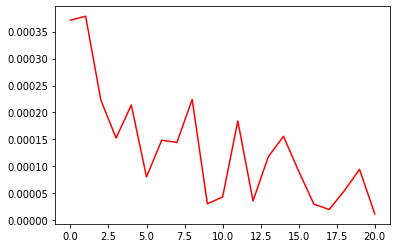

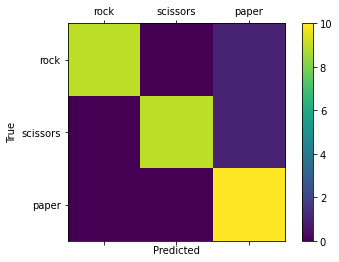

Overall Accuracy:  0.9333333333333333


In [10]:
def main():
    
    epochs = 20
    batchSize = 10
    learningRate = 1e-2

    trainer = Trainer(epochs, batchSize, learningRate)
    trainer.train()

    tester = Tester(batchSize)
    tester.test()


if __name__ == '__main__':
    main()